In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from IPython.display import display
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv("") # logs_<>.csv file for trace anomaly

# Convert stringified lists to actual Python lists
df["trace"] = df["trace"].apply(ast.literal_eval)
df["unique_activities"] = df["unique_activities"].apply(ast.literal_eval)

# Add length-based features
df["trace_length"] = df["trace"].apply(len)
df["num_unique_activities"] = df["unique_activities"].apply(len)
df["correct"] = df["prediction"] == df["true_label"]

In [ ]:
# min and max act num
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="num_unique_activities", order=sorted(df["num_unique_activities"].unique()))

display(df)

plt.title("Number of Examples by Unique Activities Number")
plt.xlabel("Unique Activities Number in Process")
plt.ylabel("Example Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

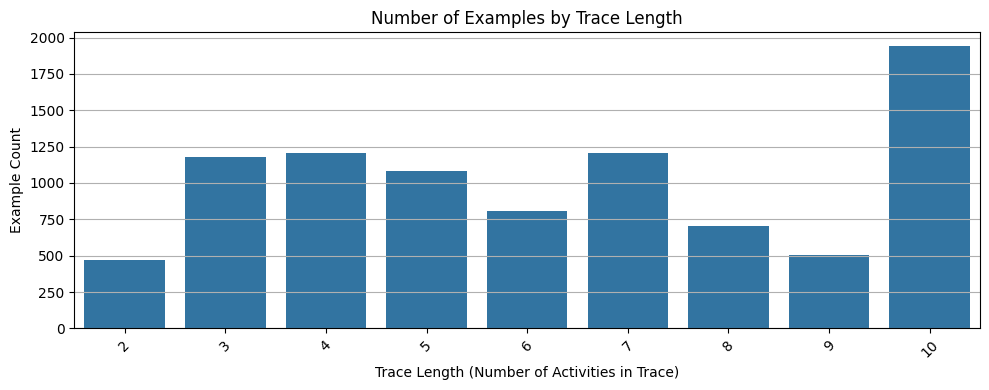

In [16]:
# Count the number of examples for each unique trace length
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="trace_length", order=sorted(df["trace_length"].unique()))

plt.title("Number of Examples by Trace Length")
plt.xlabel("Trace Length (Number of Activities in Trace)")
plt.ylabel("Example Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [ ]:
# Classify by process size (arbitrary threshold)
df["process_size"] = df["num_unique_activities"].apply(
    lambda x: "2-4" if x <= 4 else "5-7" if x <= 7 else "8-10" if x <= 10 else "11-13"
)
process_order = ["2-4", "5-7", "8-10", "11-13"]
df["process_size"] = pd.Categorical(df["process_size"], categories=process_order, ordered=True)

# Compute F1 per process size
f1_scores = []
counts = []

for size in process_order:
    group = df[df["process_size"] == size]
    if group["true_label"].nunique() > 1: 
        f1 = f1_score(group["true_label"], group["prediction"], average='macro', zero_division=0)
    else:
        f1 = float('nan')
    f1_scores.append(f1)
    counts.append(len(group))

# Build DataFrame for plotting
f1_df = pd.DataFrame({
    "process_size": process_order,
    "f1_score": f1_scores,
    "count": counts
})

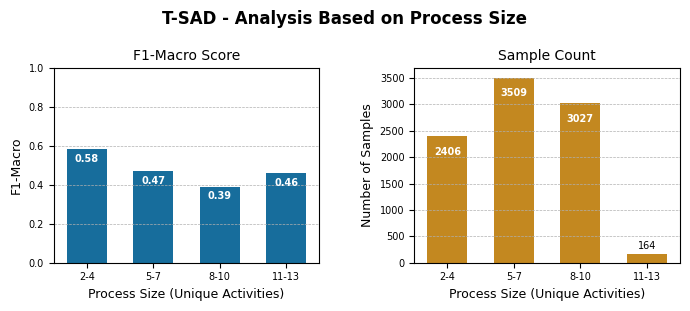

In [ ]:
# plot: T-SAD - Analysis Based on Process Size

pastel_palette = sns.color_palette("colorblind")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle("T-SAD - Analysis Based on Process Size", fontsize=12, weight="bold", y=1.02)  # 👈 General title above both plots

# Left plot: F1 Scores
sns.barplot(data=f1_df, x="process_size", y="f1_score", ax=ax1, color=pastel_palette[0], width=0.6)

for p in ax1.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 0.15:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height - 0.05),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height + 0.02),
                         ha='center', va='bottom', fontsize=7, color="blue")

ax1.set_title("F1-Macro Score", fontsize=10)
ax1.set_ylabel("F1-Macro", fontsize=9)
ax1.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax1.set_ylim(0, 1)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)


# Right plot: Sample Counts
sns.barplot(data=f1_df, x="process_size", y="count", ax=ax2, color=pastel_palette[1], width=0.6)

for p in ax2.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 500:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height - 300),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height + 50),
                         ha='center', va='bottom', fontsize=7, color="black")

ax2.set_title("Sample Count", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=9)
ax2.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

# Slightly wider distance between subplots
plt.tight_layout(rect=[0, 0, 1, 1.05], w_pad=3)  
plt.show()


,bucket,f1_score,count
0,2-4,0.583806,2857
1,5-7,0.447288,3096
2,8-10,0.396629,3153


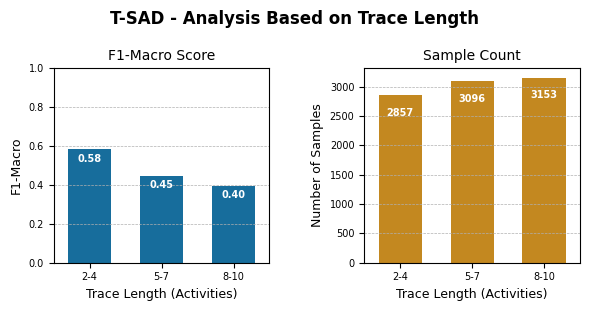

In [ ]:
# plot: T-SAD - Analysis Based on Trace Length

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

pastel_palette = sns.color_palette("colorblind")

# create trace length categories
df["trace_length_bucket"] = pd.cut(
    df["trace_length"],
    bins=[1, 4, 7, 10],  # (2-4], (5-7], (8-10]
    labels=["2-4", "5-7", "8-10"]
)

# Compute F1 score per trace length bucket
f1_records = []

for bucket in df["trace_length_bucket"].cat.categories:
    group = df[df["trace_length_bucket"] == bucket]
    if group["true_label"].nunique() > 1:  # Ensure more than one class
        f1 = f1_score(group["true_label"], group["prediction"], average='macro', zero_division=0)
    else:
        f1 = float("nan")  # Mark as NaN if not computable
    f1_records.append({"bucket": bucket, "f1_score": f1, "count": len(group)})

f1_df = pd.DataFrame(f1_records)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("T-SAD - Analysis Based on Trace Length", fontsize=12, weight="bold", y=1.02)

# Left plot: F1 Score by Trace Length
sns.barplot(data=f1_df, x="bucket", y="f1_score", ax=ax1, color=pastel_palette[0], width=0.6)

for p in ax1.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 0.15:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height - 0.05),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height + 0.02),
                         ha='center', va='bottom', fontsize=7, color="blue")

ax1.set_title("F1-Macro Score", fontsize=10)
ax1.set_ylabel("F1-Macro", fontsize=9)
ax1.set_xlabel("Trace Length (Activities)", fontsize=9)
ax1.set_ylim(0, 1)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)

# Right plot: Sample Count by Trace Length
sns.barplot(data=f1_df, x="bucket", y="count", ax=ax2, color=pastel_palette[1], width=0.6)

for p in ax2.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 500:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height - 300),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height + 50),
                         ha='center', va='bottom', fontsize=7, color="red")

ax2.set_title("Sample Count", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=9)
ax2.set_xlabel("Trace Length (Activities)", fontsize=9)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

# Tight layout: compact and control spacing
plt.tight_layout(rect=[0, 0, 1, 1.05], w_pad=3)
plt.show()


/tmp/ipykernel_3557764/2858661485.py:66: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#949494'` for the same effect.

  sns.barplot(data=metrics_melted, x="Label", y="Score", hue="Metric", ax=ax2, color=palette[7])


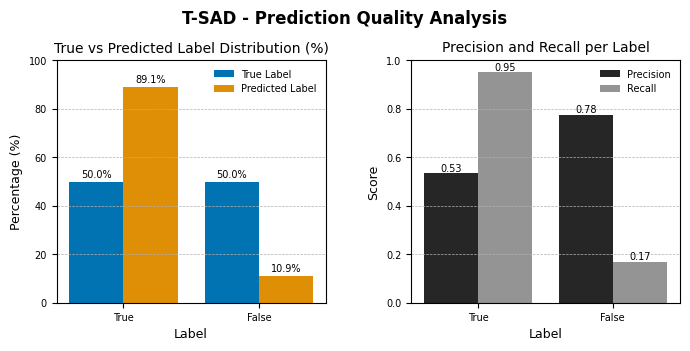

In [ ]:
# plot: T-SAD - Prediction Quality Analysis

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

# --- True vs Predicted Label Distribution ---
true_counts = df["true_label"].value_counts(normalize=True) * 100
pred_counts = df["prediction"].value_counts(normalize=True) * 100

counts_df = pd.DataFrame({
    "True Label (%)": true_counts,
    "Predicted Label (%)": pred_counts
}).reset_index().rename(columns={"index": "Label"})

# --- Precision and Recall ---
precision_true = precision_score(df["true_label"], df["prediction"], pos_label=True)
recall_true = recall_score(df["true_label"], df["prediction"], pos_label=True)
precision_false = precision_score(df["true_label"], df["prediction"], pos_label=False)
recall_false = recall_score(df["true_label"], df["prediction"], pos_label=False)

metrics_df = pd.DataFrame({
    "Label": ["True", "False"],
    "Precision": [precision_true, precision_false],
    "Recall": [recall_true, recall_false]
})
metrics_melted = metrics_df.melt(id_vars="Label", value_vars=["Precision", "Recall"], 
                                 var_name="Metric", value_name="Score")

palette = sns.color_palette("colorblind")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.3))
fig.suptitle("T-SAD - Prediction Quality Analysis", fontsize=12, weight="bold", y=1.05)

# Left plot: True vs Predicted Label Distribution
bar_width = 0.4
labels = ["True", "False"]

ax1.bar([x - bar_width/2 for x in range(len(labels))], counts_df["True Label (%)"], 
        width=bar_width, label="True Label", color=palette[0])
ax1.bar([x + bar_width/2 for x in range(len(labels))], counts_df["Predicted Label (%)"], 
        width=bar_width, label="Predicted Label", color=palette[1])

for i, (true_val, pred_val) in enumerate(zip(counts_df["True Label (%)"], counts_df["Predicted Label (%)"])):
    ax1.text(i - bar_width/2, true_val + 1, f"{true_val:.1f}%", ha='center', va='bottom', fontsize=7)
    ax1.text(i + bar_width/2, pred_val + 1, f"{pred_val:.1f}%", ha='center', va='bottom', fontsize=7)

ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels)
ax1.set_title("True vs Predicted Label Distribution (%)", fontsize=10)
ax1.set_xlabel("Label", fontsize=9)
ax1.set_ylabel("Percentage (%)", fontsize=9)
ax1.set_ylim(0, 100)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)

ax1.legend(loc="upper right", fontsize=7, frameon=False)

# Right plot: Precision and Recall
sns.barplot(data=metrics_melted, x="Label", y="Score", hue="Metric", ax=ax2, color=palette[7])

for p in ax2.patches:
    height = p.get_height()
    if height > 1e-3:
        ax2.annotate(f"{height:.2f}", 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', fontsize=7)

ax2.set_title("Precision and Recall per Label", fontsize=10)
ax2.set_ylabel("Score", fontsize=9)
ax2.set_xlabel("Label", fontsize=9)
ax2.set_ylim(0, 1)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

ax2.legend(loc="upper right", fontsize=7, frameon=False)

# Final tight layout
plt.tight_layout(rect=[0, 0, 1, 1.1], w_pad=3)
plt.show()